<a href="https://colab.research.google.com/github/Kathyllen/Compesa/blob/LabelEncoder/Estudo_de_Encerramentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importações

In [127]:
import re
import nltk
import unicodedata
import numpy as np
import pandas as pd
import datetime as dt
import xgboost as xgb
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from collections import defaultdict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [128]:
path_train = r'/content/20221025_Estudo_Encerramentos.xlsx'
path_predict = r'/content/Estudo de encerramentos.xlsx'

train_df = pd.read_excel(path_train)
predict_df = pd.read_excel(path_predict)

<ipython-input-128-cab0ff8dea43>:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  train_df = pd.read_excel(path_train)


In [129]:
predict_df = predict_df.loc[~predict_df['Número OS'].isin(train_df['Número OS'])]

In [130]:
predict_df_sampled = predict_df.sample(50, random_state = 3)

In [131]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Número OS        1576 non-null   int64         
 1   IMOV_ID          1576 non-null   int64         
 2   GERENCIA         1576 non-null   object        
 3   Município        1576 non-null   object        
 4   AM Geração OS    1576 non-null   int64         
 5   AM Encer OS      1576 non-null   int64         
 6   Dt Geração OS    1576 non-null   datetime64[ns]
 7   Dt Encer OS      1576 non-null   datetime64[ns]
 8   Tipo Serviço OS  1576 non-null   object        
 9   Unid Abert OS    1576 non-null   object        
 10  Motivo encer OS  1576 non-null   object        
 11  Parecer Enc OS   1576 non-null   object        
 12  Comentários      1576 non-null   object        
 13  Conclusão        1576 non-null   object        
dtypes: datetime64[ns](2), int64(4), object(8

In [132]:
limite_train = train_df.shape[0]

In [133]:
train_df['Conclusão'] = (train_df['Conclusão']
                         .replace(['É possível realizar o serviço.', 'Não é possível realizar o serviço.', 'Não precisa gerar outra OS. ', 'Gerar OS de remoção.', 'Gerar OS para instalar HD.', 'Inconclusivo'], 
                   [0, 1, 1, 2, 3, 4]))

In [134]:
train_df['Conclusão'].value_counts()

0    762
1    561
4    121
2     82
3     50
Name: Conclusão, dtype: int64

In [135]:
dataframe = pd.concat([train_df, predict_df_sampled], axis = 0).copy()

In [136]:
dataframe['Dt Encer OS'] = pd.to_datetime(dataframe['Dt Encer OS'])

today = pd.datetime.today()

dataframe['TEMPO_DESDE_ENCERRAMENTO'] = (dt.datetime(2022, 11, 3) - dataframe['Dt Encer OS'])

<ipython-input-136-cd487c4f836f>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime.today()


In [137]:
dataframe['TEMPO_DESDE_ENCERRAMENTO'] = dataframe['TEMPO_DESDE_ENCERRAMENTO'].dt.days

In [138]:
dataframe = dataframe.drop(columns = ['Localidade', 'Número OS', 'IMOV_ID', 'AM Geração OS', 'AM Encer OS', 'Dt Geração OS', 'Dt Encer OS'])

In [139]:
Var_Categoricas = ['GERENCIA', 'Município', 'Tipo Serviço OS', 'Unid Abert OS', 'Motivo encer OS']

In [140]:
dataframe[Var_Categoricas] = dataframe[Var_Categoricas].astype('category')

In [141]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        self.encoders = {}
        
    def fit(self, X, y=None):
        for col in self.columns:
            encoder = LabelEncoder()
            encoder.fit(X[col])
            self.encoders[col] = encoder
        return self
    
    def transform(self, X):
        X = X.copy()
        for col, encoder in self.encoders.items():
            X[col] = encoder.transform(X[col])
        return X

In [142]:
from sklearn.compose import ColumnTransformer

cat_cols = ['GERENCIA', 'Município', 'Tipo Serviço OS', 'Unid Abert OS', 'Motivo encer OS']

ct = ColumnTransformer(
    transformers=[
        ('cat', CategoricalEncoder(cat_cols), cat_cols),
        # add more transformers for other types of columns
    ],
    remainder='passthrough')

In [187]:
encoded_data = ct.fit_transform(dataframe)

In [188]:
# create a dictionary of LabelEncoders, one for each categorical column
label_encoders = {}
for col in cat_cols:
    encoder = LabelEncoder()
    encoder.fit(encoded_data[col])
    label_encoders[col] = encoder

# create a copy of X_encoded
X_decoded = encoded_data.copy()

# iterate through the categorical columns and reverse the encoding
for col, encoder in label_encoders.items():
    col_idx = encoded_data.columns.get_loc(col)
    X_decoded.iloc[:,col_idx] = encoder.inverse_transform(encoded_data.iloc[:, col_idx])

IndexError: ignored

In [183]:
for col, encoder in label_encoders.items():
  print(encoded_data.columns.get_loc(col), encoder)

0 LabelEncoder()
1 LabelEncoder()
2 LabelEncoder()
3 LabelEncoder()
4 LabelEncoder()


In [189]:
encoded_data.

AttributeError: ignored

In [182]:
X_decoded.iloc[:,4]

0       15
1       15
2       15
3       15
4       15
        ..
1621     0
1622     6
1623    13
1624    11
1625     6
Name: Motivo encer OS, Length: 1626, dtype: object

In [59]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('cat', LabelEncoder(), Var_Categoricas)], remainder='passthrough')

In [60]:
dataframe.columns

Index(['GERENCIA', 'Município', 'Tipo Serviço OS', 'Unid Abert OS',
       'Motivo encer OS', 'Parecer Enc OS', 'Comentários', 'Conclusão',
       'TEMPO_DESDE_ENCERRAMENTO'],
      dtype='object')

In [64]:
encoded_data = ct.fit_transform(dataframe)

TypeError: ignored

In [48]:
d = defaultdict(LabelEncoder)

In [17]:
LE = LabelEncoder()
for i in Var_Categoricas:
    #dataframe[i] = dataframe[[i]].apply(LE.fit_transform)
    dataframe[i] = LE.fit_transform(dataframe[i])

In [18]:
#Função para tirar símbolos e acentos e deixar o texto em lowercase:
def remove_punctuation(text):
  # Unicode normalize transforma um caracter em seu equivalente em latin.
    nfkd = unicodedata.normalize('NFKD', text)
    no_punct = u"".join([c for c in nfkd if not unicodedata.combining(c)])

    # Uso de re para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', no_punct.lower())

In [19]:
dataframe['Parecer Enc OS'] = dataframe['Parecer Enc OS'].apply(lambda x:remove_punctuation(x))

In [20]:
#Função para remover as palavras da lista:
lista_palavras = ['dia', 'visita', 'realizada', 'antonio', 'amos', 'sendo', 'santana']
def remove_words(text):
  if(type(text)==float):
    return text
  ans=""  
  for texto in text:     
    if texto not in lista_palavras:
      ans+= " " + texto
  return ans.lstrip()

In [21]:
dataframe['Parecer Enc OS'] = dataframe['Parecer Enc OS'].apply(lambda x:remove_words(x.split()))

In [22]:
train_df_ = dataframe.iloc[:limite_train,:].copy()

predict_df_ = dataframe.iloc[limite_train:,:].copy()

In [23]:
x_vec = train_df_['Parecer Enc OS'].values

ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range = (1, 3), stop_words = set(stopwords.words('portuguese')))

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(x_vec))
x_ctv = ctv.transform(x_vec) 

# Add the columns from the sparse matrix to the existing DataFrame
x_vec_com_tudo = train_df_.assign(**{col: x_ctv[:, i].toarray().ravel() for i, col in enumerate(ctv.get_feature_names_out())})

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

In [24]:
x_vec_pred = predict_df_['Parecer Enc OS'].values

ctv_pred = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range = (1, 3), stop_words = set(stopwords.words('portuguese')))

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv_pred.fit(list(x_vec_pred))
x_ctv_pred = ctv_pred.transform(x_vec_pred) 

# Add the columns from the sparse matrix to the existing DataFrame
x_vec_com_tudo_pred = (predict_df_.assign(**{col: x_ctv_pred[:, i]
                                             .toarray()
                                             .ravel() for i, col in enumerate(ctv_pred.get_feature_names())})).copy()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
# Removendo os dados que não se repetem pelo menos duas vezes
x_vec_temp = (x_vec_com_tudo_pred.iloc[:,9:]
              .loc[:, x_vec_com_tudo_pred.iloc[:,9:]
                   .sum() > 1]).copy()

x_vec_filtered = pd.concat([x_vec_com_tudo_pred.iloc[:,:9], x_vec_temp], axis=1).drop(columns= ['Parecer Enc OS', 'Comentários', 'Conclusão']).copy()

### XGBoost

In [26]:
Y = x_vec_com_tudo.iloc[:, 7]

X = x_vec_com_tudo.loc[:, x_vec_com_tudo.columns.intersection(x_vec_filtered.columns)]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)

In [27]:
reg = xgb.XGBClassifier()

reg.fit(X_train, Y_train,
        eval_metric="auc")

XGBClassifier(objective='multi:softprob')

Accuracy do modelo: 86.08%


Confusion Matrix:


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


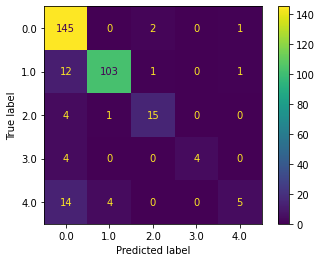

In [28]:
ypred = reg.predict(X_test)

print("Accuracy do modelo: {:.2%}".format(accuracy_score(ypred,Y_test)))
print('\n')
print('Confusion Matrix:')

plot_confusion_matrix(reg, X_test, Y_test)

plt.show()

In [29]:
X_pred = x_vec_com_tudo_pred.loc[: , x_vec_com_tudo_pred.columns[x_vec_com_tudo_pred.columns.isin(X)]]

y_pred_x = reg.predict(X_pred)

y_pred_x_index = reg.predict(X_pred.sort_index())

In [30]:
dataframe.Município.value_counts()

49    397
41    200
14    157
47    127
21    100
     ... 
30      1
19      1
59      1
24      1
44      1
Name: Município, Length: 63, dtype: int64

In [31]:
dataframe.columns

Index(['GERENCIA', 'Município', 'Tipo Serviço OS', 'Unid Abert OS',
       'Motivo encer OS', 'Parecer Enc OS', 'Comentários', 'Conclusão',
       'TEMPO_DESDE_ENCERRAMENTO'],
      dtype='object')

In [32]:
 LE.inverse_transform(X_pred['GERENCIA'])

array(['DUPLICIDADE DE SOLICITACAO', 'CODIGO SERVICO ERRADO',
       'IMOVEL NAO LOCALIZADO', 'IMOVEL DESOCUPADO', 'IMOVEL DEMOLIDO',
       'IMOVEL NAO LOCALIZADO', 'RA/OS CANCELADA', 'IMOVEL DEMOLIDO',
       'SEM REDE DE ABASTECIMENTO', 'IMOVEL FECHADO', 'RAMAL CORTADO',
       'NAO HOUVE ACORDO P/REGULARIZAR DEBITO', 'IMOVEL DEMOLIDO',
       'IMOVEL DEMOLIDO', 'NAO HOUVE ACORDO P/REGULARIZAR DEBITO',
       'IMOVEL FECHADO', 'DESISTENCIA DO USUARIO',
       'CODIGO SERVICO ERRADO', 'CODIGO SERVICO ERRADO',
       'DUPLICIDADE DE SOLICITACAO', 'RAMAL NÃO LOCALIZADO',
       'IMOVEL NAO LOCALIZADO', 'NAO CONCLUSAO DO SERVICO',
       'IMOVEL DEMOLIDO', 'NAO HOUVE ACORDO P/REGULARIZAR DEBITO',
       'RA/OS CANCELADA', 'SEM REDE DE ABASTECIMENTO',
       'SEM REDE DE ABASTECIMENTO', 'SEM REDE DE ABASTECIMENTO',
       'DESISTENCIA DO USUARIO', 'SEM REDE DE ABASTECIMENTO',
       'IMOVEL DEMOLIDO', 'NAO HOUVE ACORDO P/REGULARIZAR DEBITO',
       'CODIGO SERVICO ERRADO', 'NÃO HOUVE IRR

In [33]:
X_uncoded = pd.DataFrame()
for n, array in enumerate(Var_Categoricas):
  print(n, array)
  LE.inverse_transform(X_pred[array])
  #inv_tranformed = LE.inverse_transform(X_pred[array])
  #X_uncoded.append(inv_tranformed)

0 GERENCIA
1 Município


ValueError: ignored

In [ ]:
X_pred['Município'].value_counts()

In [ ]:
predicted_df = pd.concat([predict_df.iloc[:, :8].reset_index().drop(columns='index'), pd.Series(y_pred_x, name = 'Predição')], axis = 1)

In [ ]:
predicted_df.to_csv('Previsões OS de Encerramento.csv')

In [ ]:
predicted_df[predicted_df['Predição'] == 0]

### Top 20 Features importances

In [ ]:
dici = dict(zip(X.columns, reg.feature_importances_))

dici = dict(sorted(dici.items(), key=lambda item: item[1], reverse=True))

features = list(dici.keys())

fig, axes = plt.subplots(figsize = (8, 5))

plt.title('Feature Importance', fontsize = 15)

importances = reg.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), features, rotation = 90)
plt.show()

### Learning Curve

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(reg, X, Y, cv=5)

# calculate the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot the learning curve
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()